In [1]:
import torch, numpy as np, matplotlib.pyplot as plt, torch.nn as nn, math, seaborn as sns, cvxpy as cp, scipy, copy
from tqdm import tqdm

In [2]:
def mirror_descent_train(X_train, y_train, p, epsilon, model, potential_style, scale, lr, epoch, loss_ts, print_every, track_every=-1, init_param=None):
    loss_fn = nn.MSELoss()

    if track_every>0:
        model_track = []

    for ep in range(int(epoch)):
        loss = loss_fn(model(X_train), y_train)
        model.zero_grad()
        loss.backward()

        with torch.no_grad(): 
            for (idx, param) in enumerate(model.parameters()): 

                param_copy = torch.clone(param)           # copy current param
                grad_copy = torch.clone(param.grad)       # copy current gradient
                    
                if potential_style == 'scaled':    
                    hessian_phi = ( (p) * (p-1) * torch.abs( scale*(param_copy - init_param[idx]) )**(p-2) + 2 * epsilon ) / (epsilon+1)

                elif potential_style == 'original':    
                    return -1

                hessian_phi_star = 1 / hessian_phi
                param.data = param_copy - lr * (hessian_phi_star * grad_copy)   # update

                if track_every>0 and ep % track_every == 0:   
                    model_temp = copy.deepcopy(model)
                    model_temp.eval()
                    model_track.append(model_temp)


        if print_every>0 and ep % print_every == 0: 
            print(f"{int(ep//print_every)}/{int(epoch//print_every)}"+f" loss:{loss.item()}")

        if loss.item() < loss_ts: 
            break    
    
    if track_every<0:
        return model
    else:
        return model, model_track

In [3]:
class TwoLayer(nn.Module):
    
    def __init__(self, input_dim=1, num_neurons=100, activation='relu', inputbias_range=2):
        super(TwoLayer, self).__init__()
        
        self.input_layer = nn.Linear(input_dim, num_neurons)
        self.output_layer = nn.Linear(num_neurons, 1)

        
        self.input_layer.weight.data = self.input_layer.weight.data.uniform_(-1, 1).sign()
        self.input_layer.bias.data.uniform_(-inputbias_range, inputbias_range)
        self.output_layer.weight.data.uniform_(0,0)
        self.output_layer.bias.data.uniform_(0,0)
        
        self.num_neurons = num_neurons
        self.activation = activation
        
    def forward(self, x):
        x = self.input_layer(x) 
        if self.activation == 'relu':
            x = torch.relu(x) 
        elif self.activation == 'abs':
            x = torch.nn.functional.leaky_relu(x, negative_slope=-1.)
        x = self.output_layer(x) 
        return x
    
    def init_param(self):
        output = []
        output.append(self.input_layer.weight.data.clone())
        output.append(self.input_layer.bias.data.clone())
        output.append(self.output_layer.weight.data.clone())
        output.append(self.output_layer.bias.data.clone())
        return output

In [4]:

def solution_scaled(X, y, xrange, num_grid, p, epsilon): 

    xxx = np.linspace(-xrange, xrange, num_grid)
    delta_x = xxx[1]-xxx[0]
    idxlist = []
    for i in range(len(X)):
        idxlist.append(np.argmin( np.abs(xxx-X[i])))

    fx = cp.Variable(num_grid + 2) #fx[-2]: h'(-inf); fx[-1]: h'(inf)
    fp = (fx[1:-2] - fx[0:-3]) / delta_x  # len: num_grid - 1;    fp[0]: h'(xxx[0]) fp[-1]: h'(xxx[num_grid-2])
    lap = (fx[2:-2] - 2*fx[1:-3] + fx[0:-4]) / delta_x**2

    objective = -1 * ( cp.sum( cp.abs(lap)**p + epsilon * lap**2 ) * delta_x )
                        
    constraints = []
    for i in range(len(X)):
        constraints.append(fx[idxlist[i]]==y[i])
    
    for i in range(idxlist[0]):
        constraints.append(fp[i]==fx[-2])
        constraints.append(fp[num_grid-i-2]==fx[-1])
    for i in range(idxlist[0]-1):
        constraints.append(lap[i]==0)
        constraints.append(lap[num_grid-i-3]==0)
    
    constraints.append(fx[-2]+fx[-1]==0) # G2
    constraints.append((fx[-1]-fx[-2]) - (y[0]+y[-1])==0) # G3

    
    prob = cp.Problem(cp.Maximize(objective), constraints)
    #prob.solve(verbose=False, solver=cp.SCS)
    prob.solve(verbose=False, solver=cp.ECOS) 
    return fx.value[:-2]




def eva(model, x):
    return model(torch.tensor(x, dtype=torch.float32).reshape(-1,1)).reshape(-1).detach().numpy()


In [5]:
X = np.array([-1. , 0.35, 0.65, 1. ])
y = np.array([0.3, 0.3, 0., 0.3])
y -= .15

X_train = torch.tensor(X, dtype=torch.float32).reshape(-1, 1)
y_train = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [19]:
nlist = [20, 60, 180, 540, 1620, 4860]
model_list_4 = []
p = 4.
epsilon = 1. 
for j,n in enumerate(nlist):
    for seed in range(5):
        torch.manual_seed(seed)
        model = TwoLayer(input_dim = 1, num_neurons = n, activation='abs', inputbias_range=1.)
        model_trained = mirror_descent_train(X_train=X_train, y_train=y_train, p=p, epsilon=epsilon, model=model,
                                            potential_style='scaled', scale=n, lr=2*n**-1, 
                                            epoch=1e7, loss_ts=1e-7, print_every=-1e3, init_param=model.init_param())
        model_trained.eval()
        model_list_4.append(model_trained)
    print('finished n=', n, 'p=',p)

finished n= 20 p= 4.0
finished n= 60 p= 4.0
finished n= 180 p= 4.0
finished n= 540 p= 4.0
finished n= 1620 p= 4.0
finished n= 4860 p= 4.0


In [7]:
model_list_3 = []
p = 3.
epsilon = 1.
for j,n in enumerate(nlist):
    for seed in range(5):
        torch.manual_seed(seed)
        model = TwoLayer(input_dim = 1, num_neurons = n, activation='abs', inputbias_range=1.)
        model_trained  = mirror_descent_train(X_train=X_train, y_train=y_train, p=p, epsilon=epsilon, model=model,
                                            potential_style='scaled', scale=n, lr=1*n**-1, 
                                            epoch=1e7, loss_ts=1e-7, print_every=-1e3, init_param=model.init_param())
        model_trained.eval()
        model_list_3.append(model_trained)
    print('finished n=', n, 'p=',p)

finished n= 20 p= 3.0
finished n= 60 p= 3.0
finished n= 180 p= 3.0
finished n= 540 p= 3.0
finished n= 1620 p= 3.0
finished n= 4860 p= 3.0


In [8]:
model_list_2 = []
p = 2.
epsilon = 1.
for j,n in enumerate(nlist):
    for seed in range(5):
        torch.manual_seed(seed)
        model = TwoLayer(input_dim = 1, num_neurons = n, activation='abs', inputbias_range=1.)
        model_trained = mirror_descent_train(X_train=X_train, y_train=y_train, p=p, epsilon=epsilon, model=model,
                                            potential_style='scaled', scale=n, lr=1*n**-1, 
                                            epoch=1e7, loss_ts=1e-7, print_every=-1e3, init_param=model.init_param())
        model_trained.eval()
        model_list_2.append(model_trained)
    print('finished n=', n, 'p=',p)

finished n= 20 p= 2.0
finished n= 60 p= 2.0
finished n= 180 p= 2.0
finished n= 540 p= 2.0
finished n= 1620 p= 2.0
finished n= 4860 p= 2.0


In [20]:
xrange = 1.5
num_grid = 501
xxx = np.linspace(-xrange, xrange, num_grid)
var_solution_2 = solution_scaled(X, y, xrange, num_grid, 2, 1)
var_solution_3 = solution_scaled(X, y, xrange, num_grid, 3, 1)
var_solution_4 = solution_scaled(X, y, xrange, num_grid, 4, 1)

error_type = np.inf
errorlist_2,varlist_2 = [],[]

for i,model in enumerate(model_list_2): 
    if i % 5 == 0:
        temp_list = []

    model_output = eva(model_list_2[i], xxx) 
    temp_list.append( np.linalg.norm(model_output - var_solution_2, ord=error_type)) 

    if i%5==4:
        errorlist_2.append( np.mean(np.array(temp_list)) )
        varlist_2.append( np.std(np.array(temp_list)) )

errorlist_3,varlist_3 = [],[]
for i,model in enumerate(model_list_3): 
    if i % 5 == 0:
        temp_list = []

    model_output = eva(model_list_3[i], xxx) 
    temp_list.append( np.linalg.norm(model_output - var_solution_3, ord=error_type)) 

    if i%5==4:
        errorlist_3.append( np.mean(np.array(temp_list)) )
        varlist_3.append( np.std(np.array(temp_list)) )

errorlist_4,varlist_4 = [],[]
for i,model in enumerate(model_list_4): 
    if i % 5 == 0:
        temp_list = []

    model_output = eva(model_list_4[i], xxx) 
    temp_list.append( np.linalg.norm(model_output - var_solution_4, ord=error_type)) 

    if i%5==4:
        errorlist_4.append( np.mean(np.array(temp_list)) )
        varlist_4.append( np.std(np.array(temp_list)) )


In [13]:
class TwoLayer_Gaussian(nn.Module):
    
    def __init__(self, input_dim=1, num_neurons=100, activation='relu', sigma=1):
        super(TwoLayer_Gaussian, self).__init__()
        
        self.input_layer = nn.Linear(input_dim, num_neurons)
        self.output_layer = nn.Linear(num_neurons, 1)

        
        self.input_layer.weight.data = self.input_layer.weight.data.uniform_(-1, 1).sign()

        nn.init.normal_(self.input_layer.bias.data, mean=0.0, std=sigma)
        
        self.output_layer.weight.data.uniform_(0,0)
        self.output_layer.bias.data.uniform_(0,0)
        self.num_neurons = num_neurons
        self.activation = activation
        
    def forward(self, x):
        x = self.input_layer(x) 
        if self.activation == 'relu':
            x = torch.relu(x) 
        elif self.activation == 'abs':
            #x = torch.abs(x) 
            x = torch.nn.functional.leaky_relu(x, negative_slope=-1.)
        x = self.output_layer(x) 
        return x
    
    def init_param(self):
        output = []
        output.append(self.input_layer.weight.data.clone())
        output.append(self.input_layer.bias.data.clone())
        output.append(self.output_layer.weight.data.clone())
        output.append(self.output_layer.bias.data.clone())
        return output

In [14]:
p, epsilon = 2, 1
sigma = .5
n=4860
torch.manual_seed(0)
model = TwoLayer_Gaussian(input_dim = 1, num_neurons = n, activation='abs', sigma=sigma)
model_Gauss2  = mirror_descent_train(X_train=X_train, y_train=y_train, p=p, epsilon=epsilon, model=model,
                                    potential_style='scaled', scale=n, lr=1*n**-1, 
                                    epoch=1e7, loss_ts=1e-7, print_every=1e4, track_every=-1e2, init_param=model.init_param())
model_Gauss2.eval()

0/1000 loss:0.02250000089406967


TwoLayer_Gaussian(
  (input_layer): Linear(in_features=1, out_features=4860, bias=True)
  (output_layer): Linear(in_features=4860, out_features=1, bias=True)
)

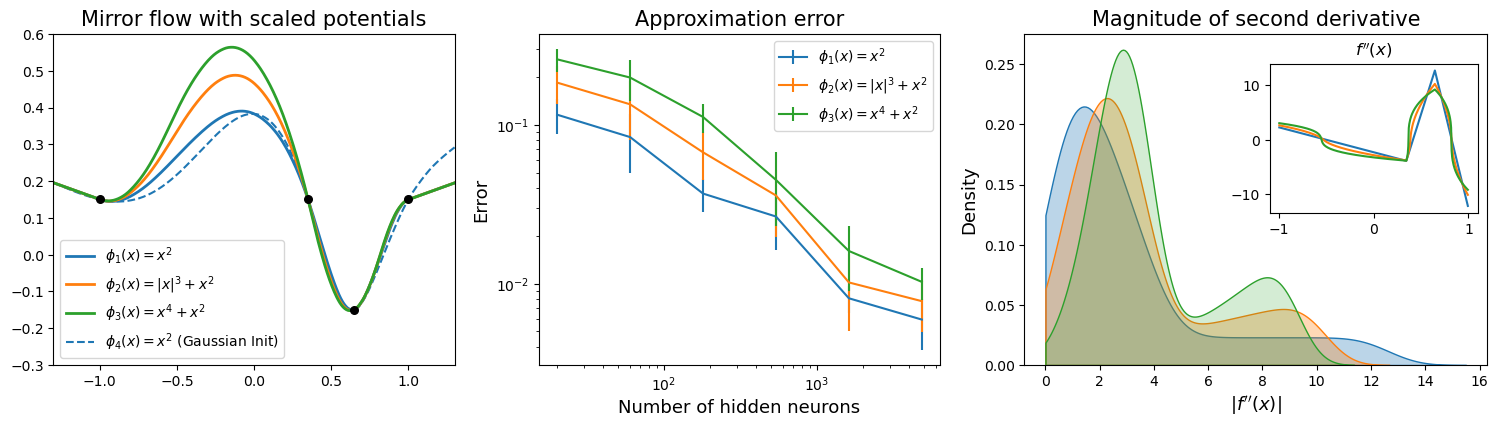

In [23]:

ylow, yhigh = -0.3, .6

FS = 13
labellist= [f'$\phi_1(x) = x^2$',f'$\phi_2(x) = |x|^3 + x^2$', f'$\phi_3(x) = x^4 + x^2$']
fig, axs = plt.subplots(1,3, figsize=(18.5,4.3),gridspec_kw={'width_ratios': [1.3, 1.3, 1.5]})

lw = 2

### left panel

ax = axs[0]
fig_xrange = 1.3
fig_x = np.linspace(-fig_xrange,fig_xrange,num_grid)
output_list = []
output_list.append(eva(model_list_2[-3], fig_x))
output_list.append(eva(model_list_3[-3], fig_x))
output_list.append(eva(model_list_4[-3], fig_x))

ax.scatter(X_train, y_train, s=30, c='black',zorder=2)
for i, output in enumerate(output_list):
    ax.plot(fig_x, output, label=labellist[i], linewidth=2, zorder=1)

ax.plot(fig_x, eva(model_Gauss2, fig_x), label=f'$\phi_4(x) = x^2$ (Gaussian Init)', lw=1.5, zorder=0, color='tab:blue', linestyle='--')
ax.legend(fontsize=FS-3)
ax.set_title("Mirror flow with scaled potentials", fontsize=FS+2)
ax.set_xlim(-1.3 , 1.3)
ax.set_ylim(ylow, yhigh)


### mid panel
ax = axs[1]
ax.errorbar(nlist, errorlist_2, yerr=varlist_2, label=labellist[0], lw=1.5) #ls='-', lw=2)#, marker='o',markersize=5)
ax.errorbar(nlist, errorlist_3, yerr=varlist_3, label=labellist[1], lw=1.5) #ls='dashed', lw=2)#, marker='o')
ax.errorbar(nlist, errorlist_4, yerr=varlist_4, label=labellist[2], lw=1.5) #ls='dotted', lw=2)#, marker='o')
ax.legend(fontsize=FS-3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title(r"Approximation error", fontsize=FS+2)
ax.set_ylabel('Error', fontsize=FS)
ax.set_xlabel('Number of hidden neurons', fontsize=FS)


### Right panel
ax = axs[2]
idx0 = np.argmin( np.abs(fig_x+1.))
idx1 = np.argmin( np.abs(fig_x-1.))

fx = solution_scaled(X,y, fig_xrange, num_grid, 2, 1)
lap2 = (fx[2:] - 2*fx[1:-1] + fx[0:-2]) / (fig_x[1]-fig_x[0])**2

fx = solution_scaled(X,y, fig_xrange, num_grid, 3, 2)
lap3 = (fx[2:] - 2*fx[1:-1] + fx[0:-2]) / (fig_x[1]-fig_x[0])**2

fx = solution_scaled(X,y, fig_xrange, num_grid, 4, 2)
lap4 = (fx[2:] - 2*fx[1:-1] + fx[0:-2]) / (fig_x[1]-fig_x[0])**2

sns.kdeplot(abs(lap2[idx0:idx1]), clip=(0., None), ax=ax, label=labellist[0], fill=True, alpha=.3)
sns.kdeplot(abs(lap3[idx0:idx1]), clip=(0., None), ax=ax, label=labellist[1], fill=True, alpha=.3)
sns.kdeplot(abs(lap4[idx0:idx1]), clip=(0., None), ax=ax, label=labellist[2], fill=True, alpha=.2)
ax.set_xlabel(f'$| f\'\'(x)|$', fontsize=FS)
ax.set_ylabel('Density', fontsize=FS)
ax.set_title('Magnitude of second derivative', fontsize=FS+2)

ax_inset = ax.inset_axes([0.53, 0.46, 0.45, 0.45])
ax_inset.plot(fig_x[idx0:idx1], lap2[idx0: idx1], label=labellist[0],lw=1.5)
ax_inset.plot(fig_x[idx0:idx1], lap3[idx0: idx1], label=labellist[1],lw=1.5)
ax_inset.plot(fig_x[idx0:idx1], lap4[idx0: idx1], label=labellist[2],lw=1.5)
ax_inset.set_title(f'$f\'\'(x)$')
ax_inset.set_xlim(-1.1, 1.1)


plt.savefig('output/figure2.png', dpi=300, bbox_inches='tight')